1. https://habr.com/ru/articles/454986/
2. https://blog.paperspace.com/dataloaders-abstractions-pytorch/
3. https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

In [1]:
### For preproccessing
import os, csv, PIL
import datetime, time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchsummary import summary

import cv2

In [3]:
from src.preprocessing import *

from src.config.loc_config import *
from src.config.data_config import *

from src.model import modelling_config
from src.model import dataset
from src.model import cnn_model
from src.model import utils

from src.model.modelling_config import *
from src.model.dataset import *
from src.model.cnn_model import *
from src.model.utils import *

from torch.utils.data import DataLoader

### Input and preprocess our data

In [7]:
# REMOVE '.ipynb_checkpoints' IN TRAIN AND TEST FOLDERS WITH IMAGES

for folder in os.listdir(TRAIN_DATA_LOC):
    path = os.path.join(TRAIN_DATA_LOC,folder,'.ipynb_checkpoints')
    !rm -r path

rm: cannot remove ‘path’: No such file or directory
rm: cannot remove ‘path’: No such file or directory
rm: cannot remove ‘path’: No such file or directory
rm: cannot remove ‘path’: No such file or directory
rm: cannot remove ‘path’: No such file or directory
rm: cannot remove ‘path’: No such file or directory
rm: cannot remove ‘path’: No such file or directory


In [8]:
for folder in os.listdir(TEST_DATA_LOC):
    path = os.path.join(TEST_DATA_LOC,folder,'.ipynb_checkpoints')
    !rm -r path

rm: cannot remove ‘path’: No such file or directory
rm: cannot remove ‘path’: No such file or directory
rm: cannot remove ‘path’: No such file or directory
rm: cannot remove ‘path’: No such file or directory
rm: cannot remove ‘path’: No such file or directory
rm: cannot remove ‘path’: No such file or directory
rm: cannot remove ‘path’: No such file or directory


In [9]:
train_df = build_annotation_dataframe(image_location = TRAIN_DATA_LOC, annot_location = ANNOT_LOC, output_csv_name = 'train.csv')
test_df = build_annotation_dataframe(image_location = TEST_DATA_LOC, annot_location = ANNOT_LOC, output_csv_name = 'test.csv')
class_names = list(train_df['class_name'].unique())
print(class_names)
print(check_annot_dataframe(train_df))
print(check_annot_dataframe(test_df))

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
[(1, 'forest'), (5, 'street'), (4, 'sea'), (3, 'mountain'), (2, 'glacier'), (0, 'buildings')]
[(1, 'forest'), (5, 'street'), (4, 'sea'), (3, 'mountain'), (2, 'glacier'), (0, 'buildings')]


In [10]:
for i in range(len(class_names)):
    num = sum(train_df['class_index'] == i)
    print(f'{class_names[i].capitalize()}:\t\t{num} images')

Buildings:		1705 images
Forest:		1629 images
Glacier:		1703 images
Mountain:		1715 images
Sea:		1646 images
Street:		1735 images


In [12]:
train_df

,file_name,file_path,class_name,class_index
0,1201.jpg,data/rawData/train/buildings/1201.jpg,buildings,0
1,8538.jpg,data/rawData/train/buildings/8538.jpg,buildings,0
2,2775.jpg,data/rawData/train/buildings/2775.jpg,buildings,0
3,146.jpg,data/rawData/train/buildings/146.jpg,buildings,0
4,8159.jpg,data/rawData/train/buildings/8159.jpg,buildings,0
...,...,...,...,...
10128,6370.jpg,data/rawData/train/street/6370.jpg,street,5
10129,12762.jpg,data/rawData/train/street/12762.jpg,street,5
10130,8755.jpg,data/rawData/train/street/8755.jpg,street,5
10131,16919.jpg,data/rawData/train/street/16919.jpg,street,5


In [6]:
# !find data/rawData -type f | wc -l

16209


###  Image transformation

#### [INTERPOLATION PILLOW](https://pillow.readthedocs.io/en/stable/reference/Image.html#resampling-filters)

In [13]:
image_transform = transform_bilinear(INPUT_WIDTH, INPUT_HEIGHT)
main_dataset = dataset.IntelDataset(annot_df = train_df, transform=image_transform)
train_dataset, validation_dataset = dataset.create_validation_dataset(main_dataset, validation_proportion = 0.2)
print('Train set size: ', len(train_dataset))
print('Validation set size: ', len(validation_dataset))

test_dataset = dataset.IntelDataset(annot_df = test_df, transform=image_transform)
print('Test set size: ', len(test_dataset))

8106 2027
Train set size:  8106
Validation set size:  2027
Test set size:  3004


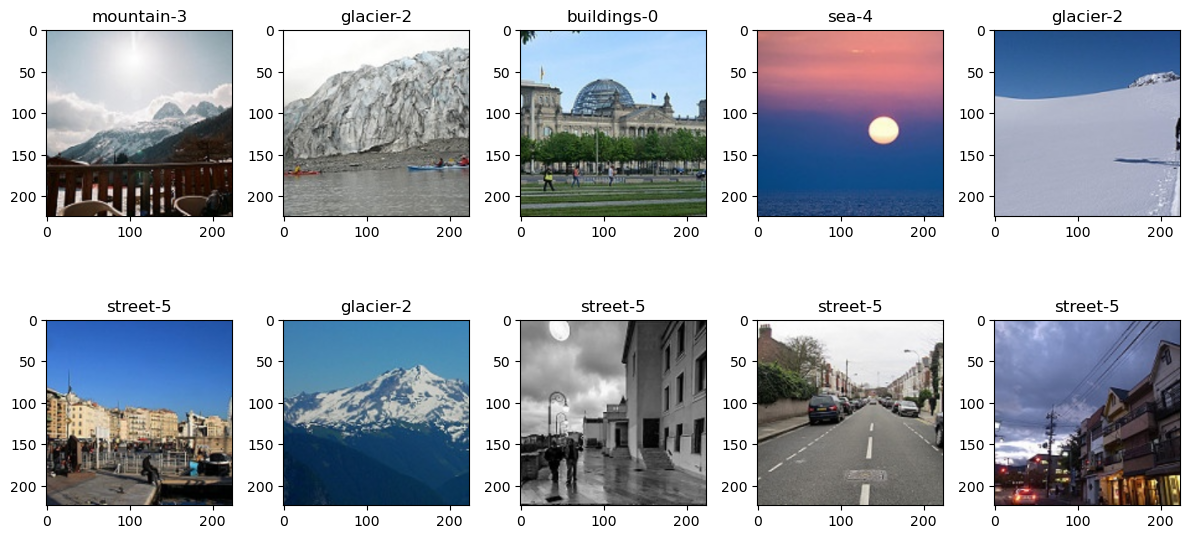

In [14]:
test_dataset.visualize()

### Configuring the Dataloaders
[DOCS](https://blog.paperspace.com/dataloaders-abstractions-pytorch/)

In [15]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)

### Model Training and Exporting

In [16]:
torch.cuda.is_available()

False

In [18]:
# initiation
model = cnn_model.MyCnnModel()
device = modelling_config.get_default_device()
modelling_config.model_prep_and_summary(model, device)
criterion = modelling_config.default_loss()
optimizer = modelling_config.default_optimizer(model = model)
num_epochs = 10

Current device: cpu
Is Model on CUDA: False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
            Conv2d-2         [-1, 16, 224, 224]           2,320
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
            Conv2d-5         [-1, 32, 112, 112]           9,248
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
            Conv2d-8           [-1, 64, 56, 56]          36,928
            Conv2d-9           [-1, 64, 56, 56]          36,928
        MaxPool2d-10           [-1, 64, 28, 28]               0
           Linear-11                  [-1, 500]      25,088,500
           Linear-12                   [-1, 50]          25,050
           Linear-13                    [-1, 6]            

data/rawData/train/street/.ipynb_checkpoints is None!
Epoch 1 	 Training Loss: 0.0 	 Validation Loss: 1.136 	 Epoch Train Accuracy (%): 41.34 	 Epoch Time (s): 813.0
data/rawData/train/street/.ipynb_checkpoints is None!
Epoch 2 	 Training Loss: 0.0 	 Validation Loss: 0.937 	 Epoch Train Accuracy (%): 59.49 	 Epoch Time (s): 850.1
data/rawData/train/street/.ipynb_checkpoints is None!
Epoch 3 	 Training Loss: 0.0 	 Validation Loss: 1.015 	 Epoch Train Accuracy (%): 65.52 	 Epoch Time (s): 851.4
data/rawData/train/street/.ipynb_checkpoints is None!
Epoch 4 	 Training Loss: 0.0 	 Validation Loss: 0.834 	 Epoch Train Accuracy (%): 72.93 	 Epoch Time (s): 915.9
data/rawData/train/street/.ipynb_checkpoints is None!
Epoch 5 	 Training Loss: 0.0 	 Validation Loss: 0.889 	 Epoch Train Accuracy (%): 77.86 	 Epoch Time (s): 869.4
data/rawData/train/street/.ipynb_checkpoints is None!
Epoch 6 	 Training Loss: 0.0 	 Validation Loss: 0.973 	 Epoch Train Accuracy (%): 82.78 	 Epoch Time (s): 876.8
data

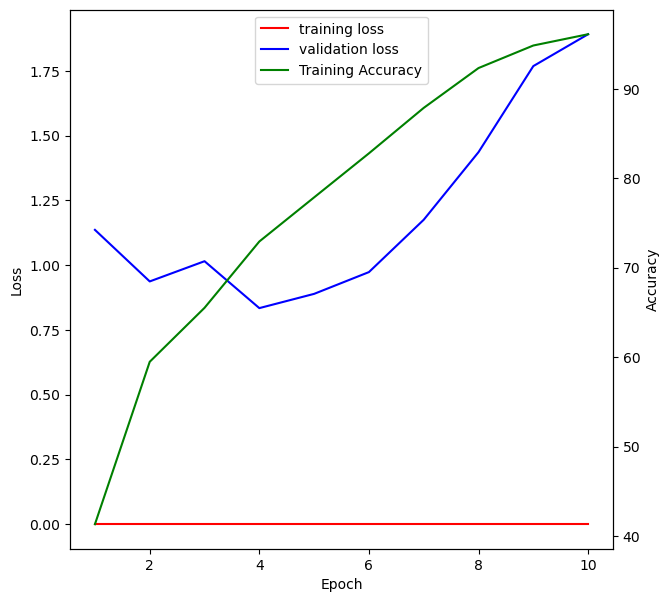

In [20]:
# get training results
trained_model, train_result_dict = cnn_model.train_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs)
cnn_model.visualize_training(train_result_dict)

### Training history

In [21]:
save_model_with_timestamp(trained_model, MODEL_SAVE_LOC)

Saved model to:  data/04_model/20230415_200637_cnn_model.pt


In [22]:
trained_model_list = os.listdir(MODEL_SAVE_LOC)
MODEL_10_EPOCH_PATH = os.path.join(MODEL_SAVE_LOC, trained_model_list[0])
MODEL_10_EPOCH = cnn_model.MyCnnModel()
device = modelling_config.get_default_device()
print(MODEL_10_EPOCH_PATH)
MODEL_10_EPOCH.load_state_dict(torch.load(MODEL_10_EPOCH_PATH))

# check accuracy on test set
y_pred, y_true = cnn_model.infer(model = MODEL_10_EPOCH, device = device, data_loader = test_loader)
confusion_matrix, class_metrics, overall_metrics = calculate_model_performance(y_pred, y_true, class_names = class_names)

print(confusion_matrix)
print(class_metrics)
print(overall_metrics)

data/04_model/20230415_200637_cnn_model.pt
data/rawData/test/sea/.ipynb_checkpoints is None!
data/rawData/test/buildings/.ipynb_checkpoints is None!
data/rawData/test/mountain/.ipynb_checkpoints is None!
data/rawData/test/street/.ipynb_checkpoints is None!
tensor([[302.,  29.,  18.,  16.,  22.,  87.],
        [  7., 393.,   1.,   0.,   2.,   7.],
        [  9.,   3., 338.,  61.,  76.,   6.],
        [ 16.,   7., 102., 324., 119.,   3.],
        [ 23.,   0.,  75., 118., 276.,   3.],
        [ 81.,  42.,  19.,   7.,  16., 396.]])
           accuracy  precision  recall  f1_score
buildings     0.897      0.637   0.689     0.662
forest        0.967      0.959   0.829     0.889
glacier       0.877      0.686   0.611     0.646
mountain      0.851      0.567   0.616     0.591
sea           0.849      0.558   0.540     0.549
street        0.910      0.706   0.789     0.745
             overall
accuracy       0.675
f1_mirco       0.675
f1_macro       0.680
f1_weighted    0.677


### TESTING ON A SINGLE IMAGE

In [24]:
image_list = os.listdir(PRED_DATA_LOC)
random_image = np.random.choice(image_list)
random_image_path = os.path.join(PRED_DATA_LOC, random_image)
print(random_image_path)

predicted_class_index = cnn_model.infer_single_image(
    model=MODEL_5_EPOCH, 
    device=device, 
    image_path=random_image_path, 
    transform=image_transform)
print(class_names[predicted_class_index])

data/rawData/pred/18229.jpg


NameError: name 'MODEL_5_EPOCH' is not defined